<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 2 Assignment 2*

# Document Representations: Bag-Of-Words

In [1]:
import re
import string

!pip install -U nltk

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize # Sentence Tokenizer
from nltk.tokenize import word_tokenize # Word Tokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Requirement already up-to-date: nltk in /home/seek/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages (3.4.4)


[nltk_data] Downloading package punkt to /home/seek/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/seek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1) (optional) Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

If you choose to not to scrape the data, there is a CSV with outdated data in the directory. Remeber, if you scrape Indeed, you're helping yourself find a job. ;)

In [2]:
##### Your Code Here #####

# Pulling job search query from indeed.com
import requests
import bs4
from bs4 import BeautifulSoup
import time

URL = 'https://www.indeed.com/jobs?q=data+scientist+%2420%2C000&start=10'
#conducting a request of the stated URL above:
page = requests.get(URL)
#specifying a desired format of “page” using the html parser - this allows python to read the various components of the page, rather than treating it as one long string.
soup = BeautifulSoup(page.text, 'html.parser')
#printing soup in a more structured tree format that makes for easier reading
print(soup.prettify())


<!DOCTYPE html>
<html dir="ltr" lang="en">
 <head>
  <meta content="text/html;charset=utf-8" http-equiv="content-type"/>
  <script src="/s/e7e2a1c/en_US.js" type="text/javascript">
  </script>
  <script>
   window.indeed=window.indeed||{};indeed.crashtext=indeed.crashtext||{};indeed.crashtext.populate=indeed.crashtext.populate||function(c,g){var d=window[g];if(d){var e=d[""]||{},h=e.salt;if(e.hasOwnProperty("salt"))for(var b in c){for(var a=void 0,a=h,f=b.length;f;)a=33*a^b.charCodeAt(--f);a>>>=0;e.hasOwnProperty("id_length")&&(a=String(a).substring(0,e.id_length));d[a]=c[b]}else for(b in c)d[b]=[null].concat(c[b])}};indeed.crashtext.populate({"indeedapply_serp_label":["Easy apply"]}, 'indeed.i18n.localeData')
  </script>
  <link href="/s/684a333/jobsearch_all.css" rel="stylesheet" type="text/css"/>
  <link href="http://rss.indeed.com/rss?q=data+scientist+%2420%2C000" rel="alternate" title="Data Scientist $20,000 Jobs, Employment" type="application/rss+xml"/>
  <link href="/m/jobs?q=da

In [3]:
# Refinning search query by job title and locations

import requests
import bs4
from bs4 import BeautifulSoup
import time

jobs = []
companies = []
locations = []
summaries = []

max_results_per_city = 50


city_set = ['New+York','Chicago','San+Francisco', 'Austin', 'Seattle', 'Los+Angeles', 
            'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 'Portland', 'Phoenix', 
            'Denver', 'Houston', 'Miami', 'Washington+DC', 'Boulder', 'Greenville', 
            'Columbia', 'Charleston', 'Charlotte', 'Savannah','Spartanburg', 'Anderson',
           'Fort+Wayne', 'Indianapolis']

for city in city_set:
      for start in range(0, max_results_per_city, 10):
        page = requests.get("https://www.indeed.com/jobs?q=data+scientist&l="
                            + str(city) + "&start=" + str(start))
        time.sleep(1)                      
        soup = BeautifulSoup(page.text, "lxml") 
        # for each row
        for div in soup.find_all(name="div", attrs={"class":"row"}):
            # Job title
            for i in div.findAll(name="a", attrs={"data-tn-element":"jobTitle"}):
                job_title = i["title"]
                if len(job_title) > 0:
                    jobs.append(job_title)
                else:
                    jobs.append('not found')
            # Company    
            for i in div.findAll(name="span", attrs={"class":"company"}):
                company = i.text
                if len(company) > 0:
                    companies.append(company)
                else:
                    companies.append('not found')
            # Location    
            for i in div.findAll("div", attrs={"class": "recJobLoc"}):
                location = i['data-rc-loc']
                if len(location) > 0:
                    locations.append(location)
                else:
                    location.append('not found')
            # Summary  
            for i in div.findAll("div", attrs={"class": "summary"}):
                summary = i.text
                if len(summary) > 0:
                    summaries.append(summary)
                else:
                    summary.append('not found')

print(len(jobs), len(companies), len(locations), len(summaries))

1988 1988 1988 1988


In [4]:
jobs = pd.DataFrame({'job_title':jobs,
          'company':companies,
          'location':locations,
          'summary':summaries})

jobs.head()

,job_title,company,location,summary
0,Data Scientist,\n\n Disney Streaming Services,"New York, NY",\nData Scientists in the ESPN+ Analytics team ...
1,Ecological Wetland Scientist,\n\n PS&S,"Mineola, NY",\n Implement field data collection ...
2,Process Data Scientist,\n\n Regeneron,"Rensselaer, NY",\n Applies advanced numerical and s...
3,Data Scientist,\n\n VISITING NURSE SERVICE OF NEW YORK,"Manhattan, NY",\n What partnerships can we develop...
4,ARD SCIENTIST,\n Epic Pharma LLC,"Springfield Gardens, NY",\nData review. Health insurance. Analytical Re...


In [5]:
jobs['company'] = jobs['company'].str.replace('[^a-zA-Z ^0-9]', '')

jobs['summary'] = jobs['summary'].str.replace('[^a-zA-Z ^0-9]', '')

jobs.head()

,job_title,company,location,summary
0,Data Scientist,Disney Streaming Services,"New York, NY",Data Scientists in the ESPN Analytics team foc...
1,Ecological Wetland Scientist,PSS,"Mineola, NY",Implement field data collection ef...
2,Process Data Scientist,Regeneron,"Rensselaer, NY",Applies advanced numerical and sta...
3,Data Scientist,VISITING NURSE SERVICE OF NEW YORK,"Manhattan, NY",What partnerships can we develop i...
4,ARD SCIENTIST,Epic Pharma LLC,"Springfield Gardens, NY",Data review Health insurance Analytical Resear...


In [6]:
jobs.to_csv('jobs.csv', index=False)

In [7]:
jobs.shape

(1988, 4)

## 2) Use Spacy to tokenize / clean the listings 

In [8]:
##### Your Code Here #####
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg", parser=False, entity=False)

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [10]:
from spacy.tokenizer import Tokenizer
tokens = []

""" Update those tokens """
for doc in tokenizer.pipe(jobs['summary'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) and (token.is_punct == False):
            doc_tokens.append(token.text.lower())
        
    tokens.append(doc_tokens)
        
jobs['tokenized summary'] = tokens

In [11]:
jobs['tokenized summary'] = tokens

In [12]:
jobs['tokenized summary'].head()

0    [data, scientists, in, the, espn, analytics, t...
1    [            , implement, field, data, collect...
2    [            , applies, advanced, numerical, a...
3    [            , what, partnerships, can, we, de...
4    [data, review, health, insurance, analytical, ...
Name: tokenized summary, dtype: object

In [13]:
jobs.head()

,job_title,company,location,summary,tokenized summary
0,Data Scientist,Disney Streaming Services,"New York, NY",Data Scientists in the ESPN Analytics team foc...,"[data, scientists, in, the, espn, analytics, t..."
1,Ecological Wetland Scientist,PSS,"Mineola, NY",Implement field data collection ef...,"[ , implement, field, data, collect..."
2,Process Data Scientist,Regeneron,"Rensselaer, NY",Applies advanced numerical and sta...,"[ , applies, advanced, numerical, a..."
3,Data Scientist,VISITING NURSE SERVICE OF NEW YORK,"Manhattan, NY",What partnerships can we develop i...,"[ , what, partnerships, can, we, de..."
4,ARD SCIENTIST,Epic Pharma LLC,"Springfield Gardens, NY",Data review Health insurance Analytical Resear...,"[data, review, health, insurance, analytical, ..."


In [16]:
# Object from Base Python
from collections import Counter

# The object `Counter` takes an iterable, but you can instaniate an empty one and update it. 
word_counts = Counter()

# Update it based on a split of each of our documents
jobs['tokenized summary'].apply(lambda x: word_counts.update(x))

# Print out the 10 most common words
word_counts.most_common(50)

[('and', 2483),
 ('            ', 1916),
 ('data', 1746),
 ('to', 1108),
 ('of', 1099),
 ('the', 890),
 ('in', 808),
 ('with', 694),
 ('a', 660),
 ('experience', 625),
 ('learning', 585),
 ('machine', 511),
 ('analytics', 424),
 ('for', 417),
 ('or', 363),
 ('as', 345),
 ('scientists', 316),
 ('statistical', 251),
 ('scientist', 248),
 ('science', 244),
 (' ', 244),
 ('will', 228),
 ('you', 217),
 ('work', 215),
 ('is', 210),
 ('are', 201),
 ('team', 199),
 ('our', 195),
 ('using', 186),
 ('years', 186),
 ('on', 171),
 ('we', 168),
 ('engineers', 162),
 ('an', 156),
 ('business', 155),
 ('deep', 155),
 ('sql', 151),
 ('techniques', 148),
 ('analysis', 144),
 ('python', 142),
 ('visualization', 142),
 ('be', 141),
 ('modeling', 137),
 ('that', 135),
 ('tools', 135),
 ('knowledge', 130),
 ('advanced', 129),
 ('r', 129),
 ('mining', 126),
 ('etc', 115)]

In [17]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [19]:
# Use the Function
wc = count(jobs['tokenized summary'])

In [20]:
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
0,and,1557,2483,1.0,0.057121,0.057121,0.783199
21,,1916,1916,2.0,0.044077,0.101199,0.963783
7,data,1109,1746,3.0,0.040167,0.141365,0.557847
43,to,921,1108,4.0,0.025489,0.166855,0.463280
29,of,866,1099,5.0,0.025282,0.192137,0.435614


In [21]:
wc[wc['rank'] <= 20]['cul_pct_total'].max()

0.3619360923876786

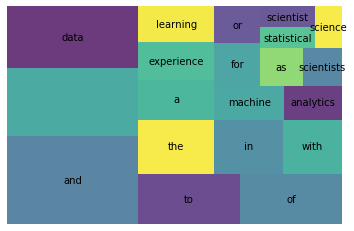

In [23]:
import squarify
import matplotlib.pyplot as plt

wc = count(jobs['tokenized summary'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [36]:
STOP_WORDS = nlp.Defaults.stop_words.union(['            '])

In [37]:
tokens = []

for doc in tokenizer.pipe(jobs['summary'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if token.text not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
jobs['tokenized summary'] = tokens

In [38]:
wc = count(jobs['tokenized summary'])

In [39]:
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
8,data,1109,1746,1.0,0.059519,0.059519,0.557847
75,experience,537,625,2.0,0.021306,0.080825,0.270121
37,learning,473,585,3.0,0.019942,0.100767,0.237928
34,machine,468,511,4.0,0.017419,0.118186,0.235412
9,analytics,313,424,5.0,0.014454,0.132640,0.157445


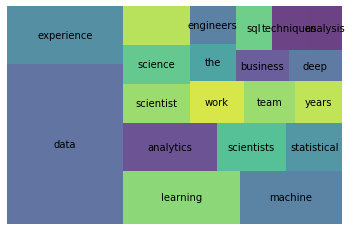

In [40]:
wc = count(jobs['tokenized summary'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [ ]:
tokens = []

for doc in tokenizer.pipe(jobs['summary'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if token.text not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
jobs['tokenized summary'] = tokens

In [55]:
# Wrap it all in a function
def get_lemmas(text):
    lemmas = []
    
    doc = nlp(text)

    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_!= 'PRON'):
            lemmas.append(token.lemma_)
            
    return lemmas

In [56]:
jobs['lemmas'] = jobs['summary'].apply(get_lemmas)

In [57]:
jobs['lemmas'].apply(lambda x: word_counts.update(x))

word_counts.most_common(50)

[('data', 5493),
 ('and', 5029),
 ('            ', 3832),
 ('datum', 3237),
 ('experience', 3164),
 ('machine', 2558),
 ('learning', 2346),
 ('the', 2272),
 ('to', 2270),
 ('of', 2201),
 ('scientist', 1990),
 ('in', 1691),
 ('a', 1416),
 ('with', 1403),
 ('analytics', 1379),
 ('work', 1342),
 ('statistical', 1255),
 ('team', 1232),
 ('science', 1229),
 (' ', 1220),
 ('as', 876),
 ('for', 873),
 ('analytic', 841),
 ('analysis', 840),
 ('be', 836),
 ('scientists', 830),
 ('business', 805),
 ('deep', 775),
 ('sql', 755),
 ('or', 747),
 ('visualization', 722),
 ('python', 710),
 ('develop', 689),
 ('project', 665),
 ('knowledge', 650),
 ('r', 645),
 ('year', 642),
 ('mining', 630),
 ('learn', 629),
 ('modeling', 616),
 ('advanced', 606),
 ('etc', 575),
 ('scientific', 560),
 ('apply', 559),
 ('build', 546),
 ('management', 545),
 ('will', 540),
 ('engineer', 524),
 ('development', 514),
 ('use', 514)]

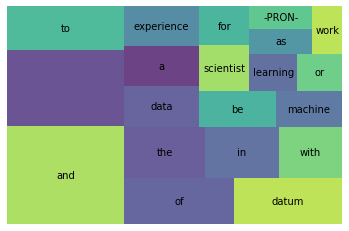

In [58]:
wc = count(jobs['lemmas'])
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

# 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [ ]:
##### Your Code Here #####
raise Exception("\nThis task is not complete. \nReplace this line with your code for the task."

# 4) Visualize the most common word counts

In [ ]:
##### Your Code Here #####
raise Exception("\nThis task is not complete. \nReplace this line with your code for the task."

 # 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [ ]:
##### Your Code Here #####
raise Exception("\nThis task is not complete. \nReplace this line with your code for the task."

 # 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [ ]:
##### Your Code Here #####
raise Exception("\nThis task is not complete. \nReplace this line with your code for the task."

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.